In [ ]:
# Automated channels

In [6]:
import pandas as pd
import requests
from datetime import datetime
import yfinance as yf
from bs4 import BeautifulSoup
import numpy as np
import math
import mplfinance as mpf

In [10]:
# Load finance data
def getdata(sym,sma_value,ema_value,close):
    yf.pdr_override()
    today = datetime.datetime.now()
    df = pdr.get_data_yahoo(sym, start=datetime.datetime(today.year-10,today.month, 1),
                                    end=datetime.datetime(today.year, today.month, today.day)).reset_index()
    df['ticker'] =sym
        
    return df


def channel_detection(data,number_back, numberbrange):
    
    df = data.copy()
    backcandles= number_back
    brange = numberbrange #should be less than backcandles
    wind = 5
    length = backcandles-brange

    candleid = df.shape[0]-1

    optbackcandles= backcandles
    sldiff = 100
    sldist = 10000000

    for r1 in range(backcandles-brange, backcandles+brange):
        maxim = np.array([])
        minim = np.array([])
        xxmin = np.array([])
        xxmax = np.array([])

        for i in range(candleid-r1, candleid+1, wind):
            minim = np.append(minim, df.Low.iloc[i:i+wind].min())
            xxmin = np.append(xxmin, df.Low.iloc[i:i+wind].idxmin())
        for i in range(candleid-r1, candleid+1, wind):
            maxim = np.append(maxim, df.High.loc[i:i+wind].max())
            xxmax = np.append(xxmax, df.High.iloc[i:i+wind].idxmax())
        slmin, intercmin = np.polyfit(xxmin, minim,1)
        slmax, intercmax = np.polyfit(xxmax, maxim,1)

        dist = (slmax*candleid + intercmax)-(slmin*candleid + intercmin)
        if(dist<sldist): #abs(slmin-slmax)<sldiff and
            #sldiff = abs(slmin-slmax)
            sldist = dist
            optbackcandles=r1
            slminopt = slmin
            slmaxopt = slmax
            intercminopt = intercmin
            intercmaxopt = intercmax
            maximopt = maxim.copy()
            minimopt = minim.copy()
            xxminopt = xxmin.copy()
            xxmaxopt = xxmax.copy()


    dfpl = df[candleid-wind-optbackcandles-backcandles:candleid+optbackcandles]  


    adjintercmax = (df.High.iloc[xxmaxopt] - slmaxopt*xxmaxopt).max()
    adjintercmin = (df.Low.iloc[xxminopt] - slminopt*xxminopt).min()
    lower = pd.DataFrame(slminopt*xxminopt + adjintercmin)
    lower['Date']=df[df.index.isin(xxminopt)].Date.values
    lower = list(zip(lower['Date'].astype(str).tolist(), lower[0].tolist()))
    upper = pd.DataFrame(slmaxopt*xxmaxopt + adjintercmax)
    upper['Date']=df[df.index.isin(xxmaxopt)].Date.values
    upper = list(zip(upper['Date'].astype(str).tolist(), upper[0].tolist()))
    
    return lower, upper

In [11]:
import matplotlib.backends.backend_pdf as pdf
import mplfinance as mpf
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages

# Placeholder functions
def getdata(ticker, sma_value, ema_value, close):
    # Example: Replace this with your actual data retrieval logic
    data = yf.download(ticker, start='2023-01-01', end='2024-01-01')
    return data

def channel_detection(df, window1, window2):
    # Example: Replace this with your actual channel detection logic
    lower = df['Close'].rolling(window=window1).min()
    upper = df['Close'].rolling(window=window2).max()
    return lower, upper

ticker = ['AAPL', 'ENPH']

# Create a PDF with multiple plots
with PdfPages('technical_analysis.pdf') as pdf_pages:
    for tic in ticker:
        df = getdata(tic, sma_value=[10, 60, 200], ema_value=[10, 60, 200], close="Close")

        lower, upper = channel_detection(df, min(500, df.shape[0] - 15), 15)
        fig, axlist = mpf.plot(df.set_index('Date').tail(650), type='candle', style='charles', mav=(5, 10, 20),
                               volume=True, figscale=1.5, title=tic + ': ' + 'long term channel detection',
                               ylabel='Price ($)', ylabel_lower='Shares\nTraded',
                               alines=dict(alines=[lower, upper], colors=['blue', 'red'], linewidths=1.0,
                                           linestyle='-'), returnfig=True)
        pdf_pages.savefig(fig)
        plt.close(fig)

        lower, upper = channel_detection(df, min(300, df.shape[0] - 15), 15)
        fig, axlist = mpf.plot(df.set_index('Date').tail(650), type='candle', style='charles', mav=(5, 10, 20),
                               volume=True, figscale=1.5, title=tic + ': ' + 'medium term channel detection',
                               ylabel='Price ($)', ylabel_lower='Shares\nTraded',
                               alines=dict(alines=[lower, upper], colors=['blue', 'red'], linewidths=1.0,
                                           linestyle='-'), returnfig=True)
        pdf_pages.savefig(fig)
        plt.close(fig)

        lower, upper = channel_detection(df, min(150, df.shape[0] - 15), 15)
        fig, axlist = mpf.plot(df.set_index('Date').tail(650), type='candle', style='charles', mav=(5, 10, 20),
                               volume=True, figscale=1.5, title=tic + ': ' + 'short term channel detection',
                               ylabel='Price ($)', ylabel_lower='Shares\nTraded',
                               alines=dict(alines=[lower, upper], colors=['blue', 'red'], linewidths=1.0,
                                           linestyle='-'), returnfig=True)
        pdf_pages.savefig(fig)
        plt.close(fig)


[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_11811/2254524953.py:22: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages('technical_analysis.pdf') as pdf_pages:


KeyError: "None of ['Date'] are in the columns"

In [4]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

with PdfPages('multipage_pdf.pdf') as pdf:
    plt.figure(figsize=(3, 3))
    plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
    plt.title('Page One')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime 
from pandas_datareader import data as pdr
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages
import mplfinance as mpf

# Load finance data
def getdata(sym,sma_value,ema_value,close):
    yf.pdr_override()
    today = datetime.datetime.now()
    df = pdr.get_data_yahoo(sym, start=datetime.datetime(today.year-10,today.month, 1),
                                    end=datetime.datetime(today.year, today.month, today.day)).reset_index()
    df['ticker'] =sym
        
    return df


def channel_detection(data,number_back, numberbrange):
    
    df = data.copy()
    backcandles= number_back
    brange = numberbrange #should be less than backcandles
    wind = 5
    length = backcandles-brange

    candleid = df.shape[0]-1

    optbackcandles= backcandles
    sldiff = 100
    sldist = 10000000

    for r1 in range(backcandles-brange, backcandles+brange):
        maxim = np.array([])
        minim = np.array([])
        xxmin = np.array([])
        xxmax = np.array([])

        for i in range(candleid-r1, candleid+1, wind):
            minim = np.append(minim, df.Low.iloc[i:i+wind].min())
            xxmin = np.append(xxmin, df.Low.iloc[i:i+wind].idxmin())
        for i in range(candleid-r1, candleid+1, wind):
            maxim = np.append(maxim, df.High.loc[i:i+wind].max())
            xxmax = np.append(xxmax, df.High.iloc[i:i+wind].idxmax())
        slmin, intercmin = np.polyfit(xxmin, minim,1)
        slmax, intercmax = np.polyfit(xxmax, maxim,1)

        dist = (slmax*candleid + intercmax)-(slmin*candleid + intercmin)
        if(dist<sldist): #abs(slmin-slmax)<sldiff and
            #sldiff = abs(slmin-slmax)
            sldist = dist
            optbackcandles=r1
            slminopt = slmin
            slmaxopt = slmax
            intercminopt = intercmin
            intercmaxopt = intercmax
            maximopt = maxim.copy()
            minimopt = minim.copy()
            xxminopt = xxmin.copy()
            xxmaxopt = xxmax.copy()


    dfpl = df[candleid-wind-optbackcandles-backcandles:candleid+optbackcandles]  


    adjintercmax = (df.High.iloc[xxmaxopt] - slmaxopt*xxmaxopt).max()
    adjintercmin = (df.Low.iloc[xxminopt] - slminopt*xxminopt).min()
    lower = pd.DataFrame(slminopt*xxminopt + adjintercmin)
    lower['Date']=df[df.index.isin(xxminopt)].Date.values
    lower = list(zip(lower['Date'].astype(str).tolist(), lower[0].tolist()))
    upper = pd.DataFrame(slmaxopt*xxmaxopt + adjintercmax)
    upper['Date']=df[df.index.isin(xxmaxopt)].Date.values
    upper = list(zip(upper['Date'].astype(str).tolist(), upper[0].tolist()))
    
    return lower, upper
    

[*********************100%%**********************]  1 of 1 completed
/home/tikam/stock-market/env3/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
/home/tikam/stock-market/env3/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=

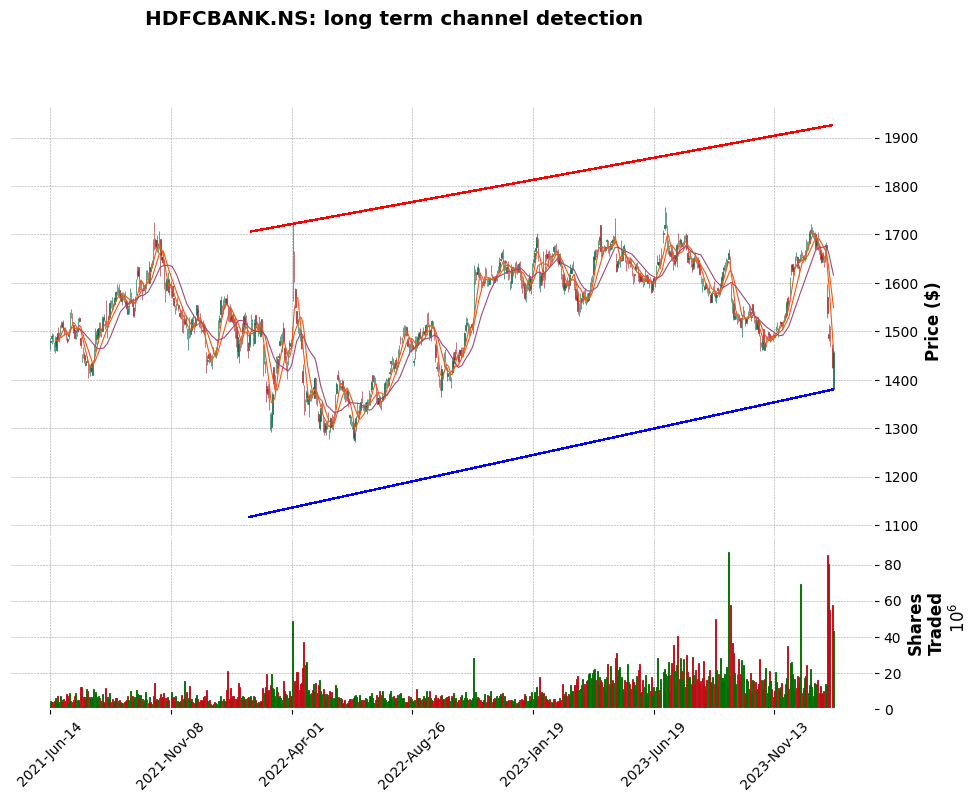

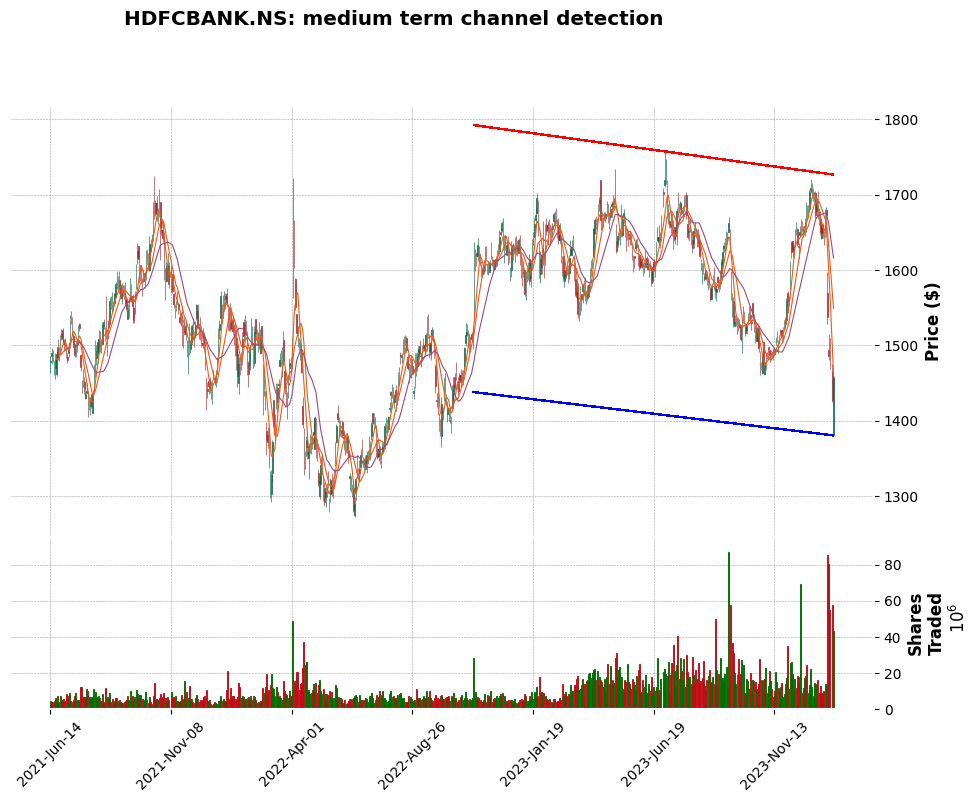

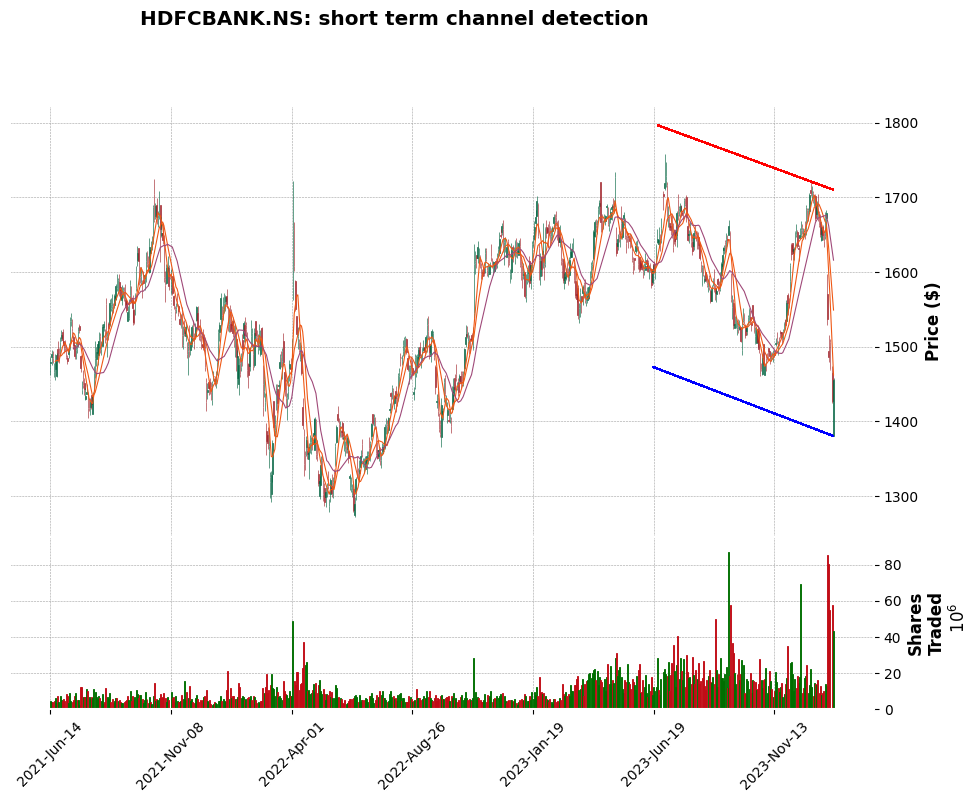

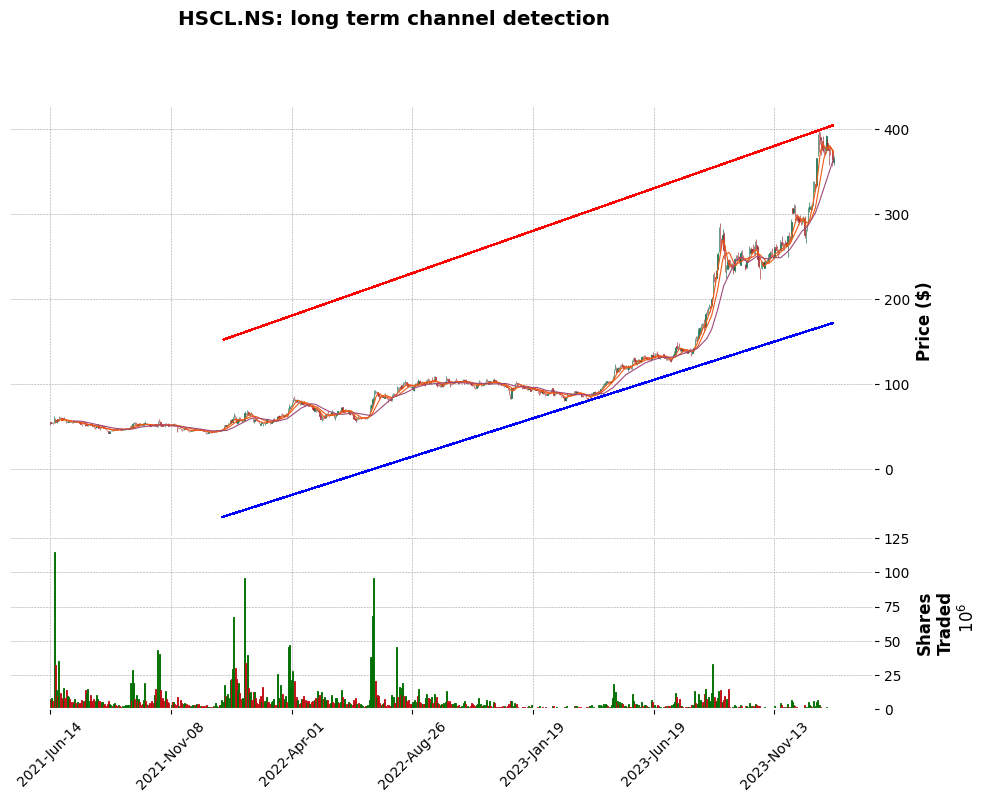

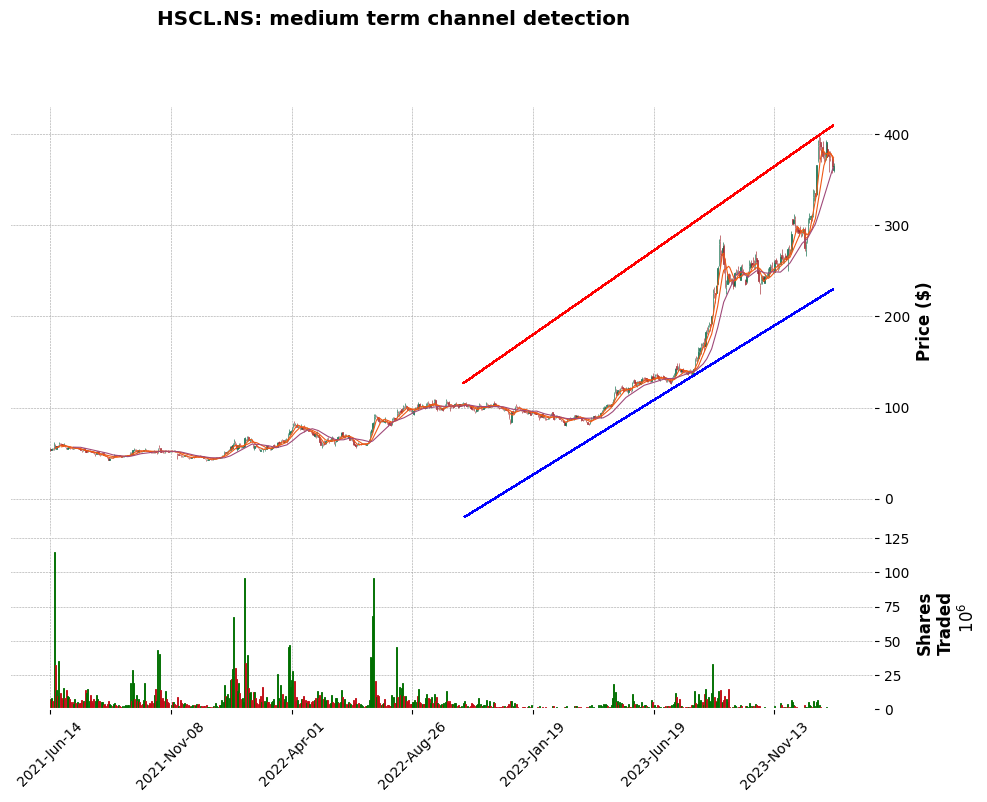

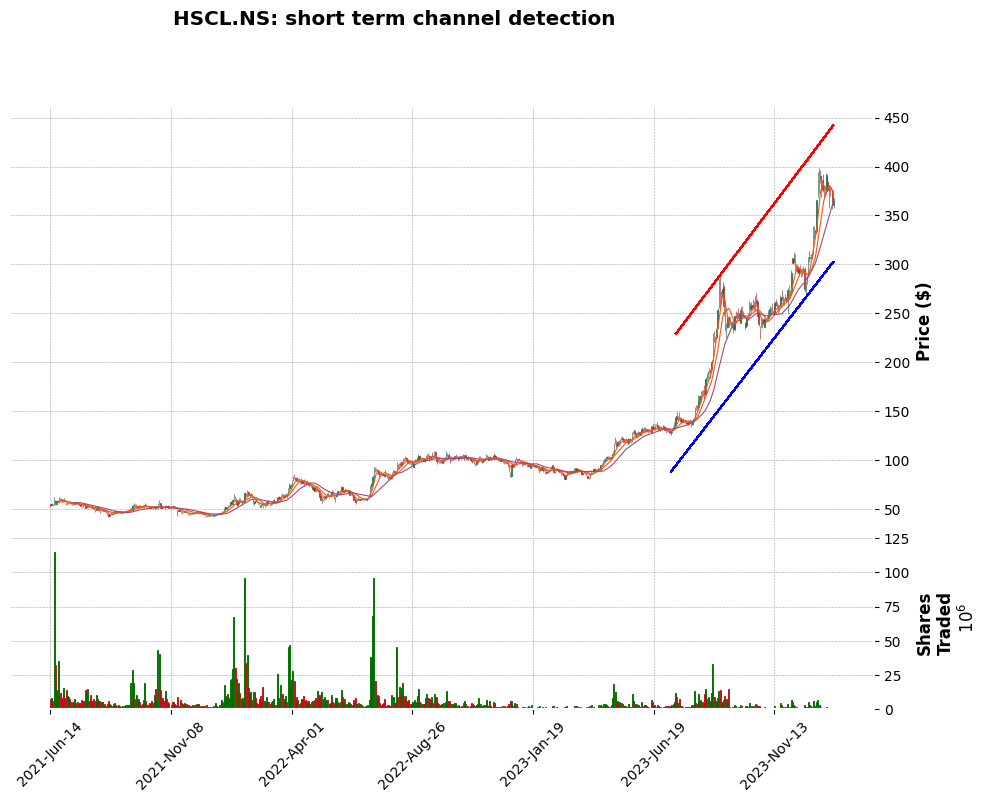

In [14]:
# Load finance data
#ticker = ['AAPL','ENPH']
#df = getdata(ticker,sma_value = [10,60,200],ema_value = [10,60,200],close = "Close")


ticker = ['HDFCBANK.NS','HSCL.NS']
with PdfPages('technical_analysis(list).pdf') as pdf:
    for tic in ticker:
        df = getdata(tic,sma_value = [10,60,200],ema_value = [10,60,200],close = "Close")

        lower, upper = channel_detection(df,min(500,df.shape[0]-15), 15)
        fig, axlist = mpf.plot(df.set_index('Date').tail(650), type='candle', style='charles', mav=(5, 10, 20), volume=True, \
                     figscale=1.5, title=tic+': '+'long term channel detection', \
                     ylabel='Price ($)', ylabel_lower='Shares\nTraded', \
                     alines=dict(alines=[lower,upper], \
                                 colors=['blue', 'red'], linewidths=1.0, linestyle='-'),returnfig=True)
        pdf.savefig(fig)
        lower, upper = channel_detection(df,min(300,df.shape[0]-15), 15)
        fig, axlist = mpf.plot(df.set_index('Date').tail(650), type='candle', style='charles', mav=(5, 10, 20), volume=True, \
                     figscale=1.5, title=tic+': '+'medium term channel detection', \
                     ylabel='Price ($)', ylabel_lower='Shares\nTraded', \
                     alines=dict(alines=[lower,upper], \
                                 colors=['blue', 'red'], linewidths=1.0, linestyle='-'),returnfig=True)
        pdf.savefig(fig)
        lower, upper = channel_detection(df,min(150,df.shape[0]-15), 15)
        fig, axlist = mpf.plot(df.set_index('Date').tail(650), type='candle', style='charles', mav=(5, 10, 20), volume=True, \
                     figscale=1.5, title=tic+': '+'short term channel detection', \
                     ylabel='Price ($)', ylabel_lower='Shares\nTraded', \
                     alines=dict(alines=[lower,upper], \
                                 colors=['blue', 'red'], linewidths=1.0, linestyle='-'),returnfig=True)
        pdf.savefig(fig)

# mpf.plot(df.set_index('Date').tail(950), type='candle', style='charles', mav=(5, 10, 20), volume=True, \
#          figscale=1.5, title=ticker+': '+'long term channel detection', \
#          ylabel='Price ($)', ylabel_lower='Shares\nTraded', \
#          alines=dict(alines=[lower,upper], \
#                      colors=['blue', 'red'], linewidths=1.0, linestyle='-'),returnfig=True)
# plt.savefig('my_figure.pdf', dpi=300)